# Airbnb Seattle Data Analysis

### Business Questions

##### The goal of this analysis is to use the Airbnb Seattle Open Dataset to answer the following questions:
    
##### Question 1: Staying in Seattle: When are the busiest times to visit? When are the most expensive times to visit? Which neighborhoods are the most and least expensive?

##### Question 2: What type of properties are advertised on Airbnb? Long stays or short-term rents? Self-catering or hotels and apartments?

##### Question 3: Which variables can be used to predict the review rating of an Airbnb property?

##### The following files will be used: listings.csv, calendar.csv

In [54]:
#Import the required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

##### It is important to view the files before performing analysis to gain an understanding of data types and shape of the dataset.

In [55]:
#Load and view the required files
listings = pd.read_csv("/Users/bethbarlow/Documents/Nanodegree/listings.csv")
calendar = pd.read_csv("/Users/bethbarlow/Documents/Nanodegree/calendar.csv")

display(calendar.shape)
display(calendar.dtypes)
display(calendar.head())

display(listings.shape)
display(listings.dtypes)
display(listings.head())

(39816, 4)

listing_id     int64
date          object
available     object
price         object
dtype: object

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


(3818, 92)

id                                    int64
listing_url                          object
scrape_id                             int64
last_scraped                         object
name                                 object
                                     ...   
cancellation_policy                  object
require_guest_profile_picture        object
require_guest_phone_verification     object
calculated_host_listings_count        int64
reviews_per_month                   float64
Length: 92, dtype: object

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


#### First we will clean both datasets before answering the questions above.

## Data Preparation: listings.csv

##### Columns that are missing significant portions of data will be removed. Here I have chosen 50% as the threshold.

In [56]:
#Display number of missing values
missing = listings.isna().sum()/len(listings)
missing.sort_values(ascending = False)

#Drop columns missing over 50% of the data
listings = listings.drop(listings.columns[listings.isnull().mean() > 0.5], axis = 1)

#### Cleaning of Numerical Variables

##### There are several numerical columns that contain symbols. These should be cleaned and converted to float. Only the year will be extracted from the 'host_since' column as this is the most relevant information. Columns containing URLs are not useful and can be dropped. It is not clear why values may be missing but an appropriate imputation method for all missing numerical variable values here is the mean of the variable. This is more appropriate than imputing 0 as some of the values are close to zero.

In [57]:
#Clean numerical variables: remove symbols and convert to float
remove_symbols = ['price', 'weekly_price', 'cleaning_fee', 'extra_people',
            'host_response_rate', 'host_acceptance_rate']

for col in remove_symbols:
        listings[col].replace('\$|,|%', '', regex = True, inplace = True)
        listings[col] = listings[col].astype(np.float64).round(decimals = 0)
        
#Extract day, month and year from date
listings['host_since_year'] = pd.to_datetime(listings['host_since']).dt.year

#Remove unnecessary columns
listings.drop(columns = ['id', 'host_id', 'scrape_id', 'last_scraped', 'host_since', 'first_review', 'last_review'], inplace = True) 

#Drop columns containing URLs
url_list = [col for col in listings.columns if '_url' in col]
listings.drop(columns = url_list, inplace = True)

#Replace missing numerical values with the mean 
num_vars = listings.select_dtypes(include = ['int64', 'float64']).columns.to_list()
for col in num_vars:
    listings[col].fillna(listings[col].mean(), inplace = True)

#### Cleaning of Categorical Variables

##### For categorical variables, missing values will be filled with 'None', in order to avoid introducing bias into the model, as often occurs using other methods such as imputing with the mode. 

In [58]:
#Impute missing values with 'None'
cat_vars = listings.select_dtypes(include = ['object']).columns.to_list()

for col in cat_vars:
    listings[col].fillna('None', inplace = True)

## Data Preparation: calendar.csv

In [59]:
calendar.date
#Remove last row as this date is invalid
calendar.drop(calendar.tail(1).index,inplace=True)

In [60]:
#Display percentage of missing values for each column
calendar.isna().sum()/len(calendar)

listing_id    0.00000
date          0.00000
available     0.00000
price         0.33839
dtype: float64

##### Columns containing symbols should be cleaned and converted to float. The date column can be broken down into day, month and year. The imputation method for the price column has been chosen as the mean. Although this is a standard method, it should be noted that the variability in the data may be underestimated as a result of this method. 

In [61]:
#Remove symbols from 'price' column
calendar['price'].replace('\$|,', '', regex = True, inplace = True)
calendar['price'] = calendar['price'].astype(np.float64)

#Change date to datetime format
calendar['date'] = pd.to_datetime(calendar['date'])

#Extract day, month and year from date
calendar['year'] = calendar['date'].dt.year
calendar['month'] = calendar['date'].dt.month
calendar['day'] = calendar['date'].dt.day

#Remove 'date' column
calendar.drop(columns = ['date'], inplace = True)

#Impute missing values from price column with mean
calendar['price'].fillna(calendar['price'].mean(), inplace = True)
calendar['price'] = calendar['price'].round(decimals = 2)

calendar.head()

,listing_id,available,price,year,month,day
0,241032,t,85.00,2016,1,4
1,241032,t,85.00,2016,1,5
2,241032,f,178.63,2016,1,6
3,241032,f,178.63,2016,1,7
4,241032,f,178.63,2016,1,8


## Data Analysis

#### Question 1(a): Which are the busiest months to visit Seattle?

##### To address this question, we can plot the percentage of properties available on the site for each month. From this we can observe a pattern of certain times of the year that are busier than others.

Text(0.5, 0, 'Month')

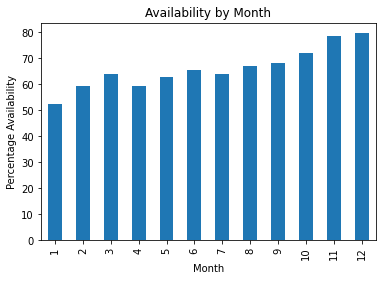

In [62]:
#Plot percentage of available properties each month
calendar_available = calendar[calendar['available'] == 't']

calendar_available.month.astype('category')
calendar.month.astype('category')

calendar_available_grouped = calendar_available.groupby('month').count()
calendar_tot_grouped = calendar.groupby('month').count()
calendar_available_perc = 100 * calendar_available_grouped['available']/calendar_tot_grouped['available']

calendar_available_perc.plot(kind = 'bar')
plt.title('Availability by Month')
plt.ylabel('Percentage Availability')
plt.xlabel('Month')

##### January is the least available month, likely due to owners blocking availability in order to complete maintenance. There is a second dip in availability during the summer months, indicating that this is the most popular time to visit the city.

#### Question 1(b): Which are the most expensive months to visit Seattle?

##### To address this question, we can use a similar method to Question 1(a) and plot the average listing price of properties each month, and observe whether there is a pattern. Here we create a function to plot a bar plot of mean of y vs x.

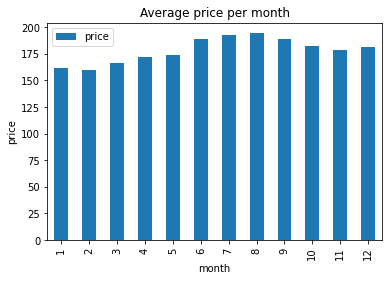

In [63]:
#Plot average price of listings each month
def barplot(df, x, y):
    '''
    This function calculates the mean value for specified numerical 'y' input 
    for each level of a categorical 'x' and plots it in a bar plot.
    
    Inputs:
    df = a dataframe
    x = column name containing values for x axis (str)
    y = column name containing values for y axis (str)
    
    Output:
    bar plot of mean values
    '''
    
    df.groupby([x]).mean().plot(kind = 'bar', y = y)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title('Average'+' '+y+' '+'per'+' '+x)
    
barplot(calendar, 'month', 'price')

##### Unsurprisingly, the plot shows that summer months are the most expensive, with ~ 14% difference between February and July.

#### Question 1(c): Where are the most and least expensive places to stay in Seattle

##### To address this question, we can calculate the average price of properties in each neighborhood and filter for the top and bottom three most expensive neighborhoods.

Text(0.5, 1.0, 'Top and Bottom Three Neighborhoods based on Average Price ($)')

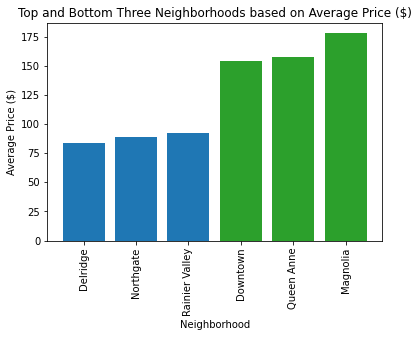

In [64]:
#Group data by neighborhood and get avg price for each neighborhood
neighborhood_price = listings.groupby('neighbourhood_group_cleansed')['price'].mean().sort_values(ascending=False).reset_index().rename(columns={'price':'Average listing price','neighbourhood_group_cleansed' : 'Neighborhood'})

#Display 3 most expensive and 3 least expensive neighborhoods
top3 = neighborhood_price.sort_values('Average listing price', ascending = False).head(3)
bottom3 = neighborhood_price.sort_values('Average listing price', ascending = False).tail(3)

top_bottom_df = pd.concat([top3, bottom3], axis = 0)
top_bottom_df.sort_values(by=['Average listing price'], inplace= True)
top_bottom_df.reset_index(drop=True, inplace= True)

#Create bar plot
plt.bar(top_bottom_df['Neighborhood'], top_bottom_df['Average listing price'], 
        color = ['C0', 'C0', 'C0', 'C2', 'C2', 'C2'])
plt.xticks(rotation=90) 
plt.xlabel("Neighborhood")
plt.ylabel("Average Price ($)")
plt.title('Top and Bottom Three Neighborhoods based on Average Price ($)')

##### There is a difference of almost $100 between Delridge and Magnolia!

#### Question 2(a): Are short stays or long-term rents more popular on Airbnb in Seattle?

##### To address this question, we can find the proportion of listings by the stated number of minimum nights. Here this is achieved using a bar chart. Bins are created manually in order that the final bin can contain all properties with minimum nights greater than 10. With automatic binning of the data, we would not be able to observe this.

Text(0, 0.5, 'Proportion of Listings')

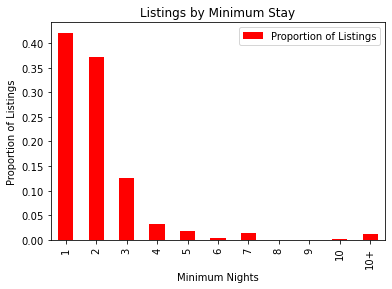

In [65]:
#Plot bar plot of proportion of listings by minimum number of nights available to rent
min_nights_counts = listings.minimum_nights.value_counts().sort_values()
values = listings.minimum_nights.to_list()
tot_listings = len(listings)

bin1 = bin2 = bin3 = bin4 = bin5 = bin6 = bin7 = bin8 = bin9 = bin10 = bin11 = 0

for val in values:
    if (val == 1):
        bin1 = bin1 + 1
    elif (val == 2):
        bin2 = bin2 + 1
    elif (val == 3):
        bin3 = bin3 + 1
    elif (val == 4):
        bin4 = bin4 + 1
    elif (val == 5):
        bin5 = bin5 + 1
    elif (val == 6):
        bin6 = bin6 + 1
    elif (val == 7):
        bin7 = bin7 + 1
    elif (val == 8):
        bin8 = bin8 + 1
    elif (val == 9):
        bin9 = bin9 + 1
    elif (val == 10):
        bin10 = bin10 + 1
    else: bin11 = bin11 + 1


data = [['1', bin1/tot_listings], ['2', bin2/tot_listings], ['3', bin3/tot_listings],
['4', bin4/tot_listings], ['5', bin5/tot_listings], ['6', bin6/tot_listings], ['7', bin7/tot_listings], ['8', bin8/tot_listings], 
['9', bin9/tot_listings], ['10', bin10/tot_listings], ['10+', bin11/tot_listings]]

df = pd.DataFrame(data, columns=['Minimum Nights', 'Proportion of Listings'])

df.sort_index().plot(x = 'Minimum Nights', kind = 'bar', color = 'red')
plt.title('Listings by Minimum Stay')
plt.ylabel('Proportion of Listings')

##### Almost half of properties have a minimum stay of two or three nights, indicating that hosts are inclined towards listing their property for a short-term stay rather than simply overnight. At the other extreme, under five percent of properties state a minimum stay of over ten nights, so the platform does not cater as well for those seeking a long-term rental.

#### Question 2(b): Which type of property and room is most popular amongst Airbnb owners

##### A simple table of percentage of listings of each property time will suffice to answer this question

In [66]:
#Calculate % of each property type in the dataset
prop_type_perc = listings['property_type'].value_counts()/len(listings['property_type'])*100

#Rename the columns from the output above
prop_type_perc = prop_type_perc.rename_axis("Property Type").reset_index(name="% of Listed Properties")
prop_type_perc

,Property Type,% of Listed Properties
0,House,45.390257
1,Apartment,44.735464
2,Townhouse,3.090623
3,Condominium,2.383447
4,Loft,1.047669
5,Bed & Breakfast,0.969094
6,Other,0.576218
7,Cabin,0.550026
8,Camper/RV,0.340492
9,Bungalow,0.340492


##### Unsurprisingly, apartments and houses account for the overwhelming majority of properties listed, although there are a small number of unconventional stays also available.

##### A pie chart is a nice visualisation to highlight the proportion of properties advertising different room types.

Text(0.5, 1.0, 'Breakdown of room types')

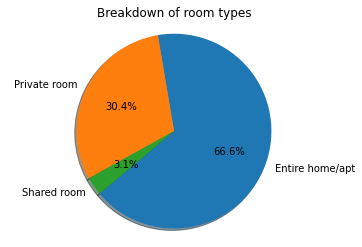

In [67]:
#Plot percentage of each room type listed
room_type_perc = listings['room_type'].value_counts()/len(listings['room_type']) * 100
labels = room_type_perc.index.to_list()
sizes = room_type_perc.values

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels = labels, autopct='%1.1f%%', shadow = True, startangle = 220)
ax1.axis('equal')
plt.title('Breakdown of room types')

##### We can see that two thirds of all listings are entire properties, although there is a significant proportion of private rooms within a shared accommodation.

#### Question 3: Which variables can be used to predict the review rating of an Airbnb property?

##### To address this question, first we should check the correlations of all varibles in the listings.csv dataset. Those which are highly correlated can be removed as they do not add additional information to the model, only increase complexity, which is undesirable.

In [68]:
#Data Preparation for Linear Regression Model
#Check correlation between variables
corr_mat = listings.corr()
corr_mat.style.background_gradient(cmap='coolwarm')

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,weekly_price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,host_since_year
host_response_rate,1.000000,-0.007316,0.022069,0.022069,-0.019719,-0.011481,0.005089,0.007692,-0.004274,0.014804,-0.012718,0.002836,-0.051420,0.061139,0.017337,0.006593,-0.022881,-0.041899,-0.031257,-0.027112,-0.079977,0.102110,0.130052,0.110400,0.140264,0.126431,0.133179,0.059357,0.125145,-0.086761,0.147892,-0.011957
host_acceptance_rate,-0.007316,1.000000,0.004341,0.004341,0.003969,-0.002701,0.011334,0.006975,0.005215,0.010602,0.004848,-0.000849,0.015890,0.008528,0.009980,-0.000643,-0.003618,-0.016366,-0.014557,-0.013514,-0.014560,0.008615,-0.014622,0.016288,-0.009632,-0.006525,-0.006154,-0.010885,0.010909,0.006619,0.017204,-0.008915
host_listings_count,0.022069,0.004341,1.000000,1.000000,-0.012511,-0.000055,0.111197,0.068197,0.065590,0.085480,0.093938,0.017952,0.185542,-0.059285,-0.063477,0.001894,0.022683,0.119753,0.124693,0.123996,0.085980,-0.062214,-0.088936,-0.099988,-0.035853,-0.155100,-0.111594,0.019648,-0.092845,0.224216,-0.098124,-0.046104
host_total_listings_count,0.022069,0.004341,1.000000,1.000000,-0.012511,-0.000055,0.111197,0.068197,0.065590,0.085480,0.093938,0.017952,0.185542,-0.059285,-0.063477,0.001894,0.022683,0.119753,0.124693,0.123996,0.085980,-0.062214,-0.088936,-0.099988,-0.035853,-0.155100,-0.111594,0.019648,-0.092845,0.224216,-0.098124,-0.046104
latitude,-0.019719,0.003969,-0.012511,-0.012511,1.000000,-0.155092,0.000335,-0.014959,0.039083,0.022993,-0.008904,-0.021001,0.010953,0.034452,0.002132,-0.001222,-0.004705,-0.019751,-0.037074,-0.036991,0.000565,-0.032761,-0.034636,-0.013684,-0.034687,-0.016683,-0.022819,0.087836,-0.017693,0.026750,-0.077492,-0.004824
longitude,-0.011481,-0.002701,-0.000055,-0.000055,-0.155092,1.000000,-0.071584,-0.017027,-0.055021,-0.067674,-0.102420,-0.080161,-0.084126,-0.023828,0.005851,0.003406,-0.010435,-0.007231,0.002575,0.008444,-0.007926,-0.008260,-0.042707,-0.033494,-0.056670,-0.042526,-0.055738,-0.172506,-0.039801,0.086343,0.002346,0.012990
accommodates,0.005089,0.011334,0.111197,0.111197,0.000335,-0.071584,1.000000,0.537918,0.770594,0.861107,0.652218,0.462197,0.592331,0.532796,0.148390,0.017097,0.003291,-0.043169,-0.048761,-0.060468,-0.031535,-0.072978,-0.012023,-0.045524,0.010681,-0.018027,-0.012116,-0.034408,-0.056889,-0.029525,-0.132780,-0.094409
bathrooms,0.007692,0.006975,0.068197,0.068197,-0.014959,-0.017027,0.537918,1.000000,0.610570,0.532199,0.516017,0.352088,0.471165,0.304504,0.079327,0.006358,-0.015318,-0.039366,-0.049330,-0.057267,-0.002323,-0.091686,0.041281,-0.005616,0.016511,-0.002676,-0.014479,-0.008199,0.013075,-0.002730,-0.154323,-0.053088
bedrooms,-0.004274,0.005215,0.065590,0.065590,0.039083,-0.055021,0.770594,0.610570,1.000000,0.752944,0.627596,0.441044,0.570210,0.456939,0.108822,0.011957,-0.008590,-0.076506,-0.090157,-0.103084,-0.049767,-0.105304,0.020972,-0.010763,-0.007289,0.009478,0.001007,-0.026128,-0.001086,-0.045541,-0.208832,-0.073947
beds,0.014804,0.010602,0.085480,0.085480,0.022993,-0.067674,0.861107,0.532199,0.752944,1.000000,0.589306,0.398370,0.570965,0.460496,0.130837,0.002670,-0.009114,-0.028567,-0.036429,-0.047565,-0.009772,-0.089073,-0.000665,-0.048712,0.004370,-0.020275,-0.012351,-0.021913,-0.026868,0.010536,-0.138010,-0.073161


In [69]:
#Remove variables with higher than 85% correlation. This is a subjective threshold and may be altered.
listings.drop(columns = ['host_total_listings_count', 'beds', 'availability_60', 'availability_90'], inplace = True)

In [70]:
listings.shape

(3818, 70)

##### We don't want categorical variables with only one level, and to avoid an overly complex model, neither do we want variables with a very high number of levels. To address this, we select only those variables with levels between these two thresholds. 

In [71]:
#Find and remove categorical variables that have either 1 level or over 100 levels (to avoid an overly complex model)
cat_vars = listings.select_dtypes(include = ['object']).columns.to_list()

cat_df = listings[cat_vars]

cat_vars_count = listings[cat_vars].nunique().sort_values(ascending = False)

cat_vars_to_keep = cat_vars_count[cat_vars_count.between(2, 100, inclusive = 'both')].index.to_list()
cat_vars_to_keep

['neighbourhood_cleansed',
 'neighbourhood',
 'calendar_updated',
 'zipcode',
 'property_type',
 'neighbourhood_group_cleansed',
 'smart_location',
 'city',
 'host_response_time',
 'bed_type',
 'host_has_profile_pic',
 'cancellation_policy',
 'host_identity_verified',
 'host_is_superhost',
 'room_type',
 'require_guest_profile_picture',
 'instant_bookable',
 'state',
 'is_location_exact',
 'require_guest_phone_verification']

##### Here we keep only those variables that we believe may have predictive power in the model. Again, this is subjective and based on knowledge of the industry.

In [72]:
#Manually select final categorical variables for linear regression model
cat_vars_to_keep_final = [
     'neighbourhood_group_cleansed', 
     'property_type', 
     'host_response_time',
     'room_type',
     'host_has_profile_pic',
     'cancellation_policy',
     'host_identity_verified',
     'host_is_superhost',
     'instant_bookable',
     'is_location_exact',
     'require_guest_phone_verification']

#Select categorical variables to drop
cat_vars_to_drop_final = cat_df.drop(columns = [col for col in cat_df if col in cat_vars_to_keep_final], inplace = False).columns.to_list()
len(cat_vars_to_drop_final)

31

In [73]:
listings.drop(cat_vars_to_drop_final, axis = 1, inplace = True)
listings.shape

(3818, 39)

##### Dummy variables should be created for each categorical variable, and the original column dropped.

In [74]:
#For each category, add dummy variable and drop original column
for var in listings[cat_vars_to_keep_final].columns:
    listings = pd.concat([listings.drop(var, axis=1), pd.get_dummies(listings[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
#Confirm that final dataframe has over 10 times number of rows as columns
display(listings.shape[0]/listings.shape[1])
display(listings.head())

49.58441558441559

,host_response_rate,host_acceptance_rate,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,price,weekly_price,...,host_has_profile_pic_t,cancellation_policy_moderate,cancellation_policy_strict,host_identity_verified_f,host_identity_verified_t,host_is_superhost_f,host_is_superhost_t,instant_bookable_t,is_location_exact_t,require_guest_phone_verification_t
0,96.000000,100.000000,3.0,47.636289,-122.371025,4,1.0,1.0,85.0,788.481832,...,1,1,0,0,1,1,0,0,1,0
1,98.000000,100.000000,6.0,47.639123,-122.365666,4,1.0,1.0,150.0,1000.000000,...,1,0,1,0,1,0,1,0,1,1
2,67.000000,100.000000,2.0,47.629724,-122.369483,11,4.5,5.0,975.0,788.481832,...,1,0,1,0,1,1,0,0,1,0
3,94.886798,99.967159,1.0,47.638473,-122.369279,3,1.0,0.0,100.0,650.000000,...,1,0,0,0,1,1,0,0,1,0
4,100.000000,99.967159,2.0,47.632918,-122.372471,6,2.0,3.0,450.0,788.481832,...,1,0,1,0,1,1,0,0,1,0


##### To prepare the data for linear regression, training and test datasets can be created in order for us to observe the performance of the model out of sample.

In [75]:
#Multiple Linear Regression

#Drop rows missing review scores (dependent variable)
listings_lm = listings.dropna(subset = ['review_scores_rating'], axis  = 0)
y = listings_lm['review_scores_rating']
X = listings_lm.drop('review_scores_rating', axis = 1)

In [76]:
pd.set_option('display.max_columns', None)
listings_lm

,host_response_rate,host_acceptance_rate,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,price,weekly_price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,host_since_year,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Magnolia,neighbourhood_group_cleansed_Northgate,neighbourhood_group_cleansed_Other neighborhoods,neighbourhood_group_cleansed_Queen Anne,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle,property_type_Bed & Breakfast,property_type_Boat,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_House,property_type_Loft,property_type_None,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,room_type_Private room,room_type_Shared room,host_has_profile_pic_f,host_has_profile_pic_t,cancellation_policy_moderate,cancellation_policy_strict,host_identity_verified_f,host_identity_verified_t,host_is_superhost_f,host_is_superhost_t,instant_bookable_t,is_location_exact_t,require_guest_phone_verification_t
0,96.000000,100.000000,3.0,47.636289,-122.371025,4,1.0,1.0,85.0,788.481832,61.710904,2,5.0,1,365,14,346,207,95.000000,10.000000,10.000000,10.000000,10.000000,9.000000,10.000000,2,4.070000,2011.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,1,0
1,98.000000,100.000000,6.0,47.639123,-122.365666,4,1.0,1.0,150.0,1000.000000,40.000000,1,0.0,2,90,13,291,43,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,6,1.480000,2013.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1
2,67.000000,100.000000,2.0,47.629724,-122.369483,11,4.5,5.0,975.0,788.481832,300.000000,10,25.0,4,30,1,220,20,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2,1.150000,2014.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,1,0,0,1,0
3,94.886798,99.967159,1.0,47.638473,-122.369279,3,1.0,0.0,100.0,650.000000,61.710904,1,0.0,1,1125,0,143,0,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,1,2.078919,2013.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0
4,100.000000,99.967159,2.0,47.632918,-122.372471,6,2.0,3.0,450.0,788.481832,125.000000,6,15.0,1,1125,30,365,38,92.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1,0.890000,2011.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,99.000000,100.000000,354.0,47.664295,-122.359170,6,2.0,3.0,359.0,788.481832,230.000000,1,0.0,3,1125,18,32,1,80.000000,8.000000,10.000000,4.000000,8.000000,10.000000,8.000000,8,0.300000,2015.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,1,0

In [77]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 42) 

In [78]:
#Instantiate and fit linear model
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)

LinearRegression(normalize=True)

In [79]:
#Predict using the model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#Score using the model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

train_score, test_score

(0.6538037667223555, 0.4085803743663138)

##### The r-squared score for the model fit on the train dataset is better than that for the test dataset. There is likely to be overfitting, and to combat this, it may be useful to fit the model many times with different rows and average the responses,or subset the features used for fitting the model each time.

In [80]:
#Produce dataframe with column names and linear model coefficients
coeffs = pd.DataFrame()
coeffs['variable'] = X_train.columns
coeffs['coefficient'] = lm_model.coef_
coeffs['abs_coefficient'] = np.abs(lm_model.coef_)
coeffs = coeffs.sort_values('abs_coefficient', ascending=False)
coeffs.reset_index().head(15)

,index,variable,coefficient,abs_coefficient
0,72,host_is_superhost_t,1.371912e+13,1.371912e+13
1,71,host_is_superhost_f,1.371912e+13,1.371912e+13
2,66,host_has_profile_pic_t,-7.037224e+12,7.037224e+12
3,65,host_has_profile_pic_f,-7.037224e+12,7.037224e+12
4,69,host_identity_verified_f,-6.681900e+12,6.681900e+12
5,70,host_identity_verified_t,-6.681900e+12,6.681900e+12
6,50,property_type_Dorm,3.004007e+00,3.004007e+00
7,23,review_scores_value,2.906900e+00,2.906900e+00
8,48,property_type_Chalet,-2.744377e+00,2.744377e+00
9,59,host_response_time_a few days or more,-2.473036e+00,2.473036e+00


##### Finally we prepare the above table to increase readability for the blog post

In [81]:
#Trim dataframe to remove repeated dummies and change names for readability
coeffs_trim = coeffs.iloc[[0,3,4,6,7,8,9,10,11,12]]

coeffs_trim['variable'] = ['Superhost: True',
                      'No Host Profile Pic',
                      'Host Identify Unverified',
                      'Property Type: Dorm',
                      'Review Scores: Value',
                      'Property Type: Chalet',
                      'Host Response Time: A few days or more',
                     'Review Scores: Cleanliness',
                          'Review Scores: Accuracy',
                          'Property Type: Yurt']

coeffs_trim.rename(columns={'variable': 'Variable', 'coefficient': 'Coefficient', 'abs_coefficient':'Absolute Value of Coefficient'}, inplace=True)
coeffs_trim

/var/folders/pp/yp7ffdpd6x98ps00y1b42jjm0000gn/T/ipykernel_29202/3386321076.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coeffs_trim['variable'] = ['Superhost: True',
/Users/bethbarlow/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,Variable,Coefficient,Absolute Value of Coefficient
72,Superhost: True,1.371912e+13,1.371912e+13
65,No Host Profile Pic,-7.037224e+12,7.037224e+12
69,Host Identify Unverified,-6.681900e+12,6.681900e+12
50,Property Type: Dorm,3.004007e+00,3.004007e+00
23,Review Scores: Value,2.906900e+00,2.906900e+00
48,Property Type: Chalet,-2.744377e+00,2.744377e+00
59,Host Response Time: A few days or more,-2.473036e+00,2.473036e+00
19,Review Scores: Cleanliness,1.908576e+00,1.908576e+00
18,Review Scores: Accuracy,1.880206e+00,1.880206e+00
58,Property Type: Yurt,1.796994e+00,1.796994e+00


##### This shows the top ten variables with the highest regression coefficients. It can be seen that the top three most powerful variables are all related to identity of the host, namely superhost status, existence of a profile picture and verifiability of the host’s identify.

##### Whilst dormitories, chalets and yurts seem to have a strong relationships with review rating, only two or fewer Seattle properties were of each type, so it’s likely that these were anomalies and it’s not possible to say anything about the predictive power of these variables in general. Unsuprisingly other types of review score including those related to value for money, cleanliness and description accuracy also display positive relationships with overall rating.